#### Training vector-based models

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict, namedtuple
import re
from tqdm.auto import tqdm

from nltk.tokenize import word_tokenize

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.callbacks import CallbackAny2Vec

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import tensorflow as tf
# import tensorflow.keras as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from eval_utils import create_metrics

/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-02 09:46:51.787702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743601611.798687  486255 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743601611.801991  486255 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743601611.811264  486255 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more t

In [2]:
tqdm.pandas()

tf.keras.backend.clear_session()

Define constants

In [3]:

dim=50
hidden_size = 128
inname = "c_nurse"
outname = "c_nurse"
per_category_limit = None

Method for downsampling unbalanced data

In [4]:
def limit_samples(df, group, max_count):
    return df.groupby(group).apply(lambda x: x if len(x) <= max_count else x.sample(max_count)).droplevel(0)

Loading datasets(segmented and normalized)

In [5]:
parts = pd.read_feather(f"dataset/{inname}-parts.feather")
titles = pd.read_feather(f"dataset/{inname}-titles.feather")

In [6]:
# downsample
relevant = parts
if per_category_limit is not None:
    relevant = limit_samples(parts, "label", per_category_limit)
relevant = relevant.query("label >= 0").reset_index(drop=True) # remove -1: unlabeled

In [7]:
relevant.head(3)


,rid,pid,rord,srord,text,stext,title,stitle,label
0,1678764,2,1,3,"PNS: A pos, Ab neg, HBSAg neg, RPR NR, RI, GB...","A pos, Ab neg, HBSAg neg, RPR NR, RI, GBS neg....",PNS,pns,183
1,1678764,2,1,6,Assessment/plan:\nTerm male infant with increa...,Term male infant with increased risk of sepsis...,Assessment/plan,assessment/plan,42
2,1260685,3,1,0,MICU NSG PROG NOTE: days\nRemains stable on hi...,"days\nRemains stable on high dose neo, taperin...",MICU NSG PROG NOTE,micu nsg prog note,700


Prepairing train/test

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# only using the first fold
for train_index, test_index in skf.split(relevant, relevant.label):
    break

Tokenizers

In [10]:
def tokenize_doc(text):
    text = re.sub(r"[0-9]", "9", text) # replace all digits with 9
    text = re.sub(r"([\.\,\:])(?!#)", r" \1 ", text) # space around punctuation
    text = re.sub(r"\n", r" <br> ", text) # Replaces newlines with <br> tag : To preserve line breaks as meaningful information / avoid issues caused by invisible characters like \n
    return text.split()

def tokenize_nltk(text):
    text = re.sub(r"[0-9]", "9", text)
    text = re.sub(r"\n", r" <br> ", text)
    return word_tokenize(text) # NLTK's word_tokenize, which is smarter than .split()


In [11]:
# select the tokenizer
tokenize = tokenize_doc

Create the dataset

In [12]:
def make_dataset(relevant, indexer, tokenize_function, numproc=12):
    # Create a tokenized dataset using both original text and segmented text (stext) from the relevant object.
    df = pd.concat([
        pd.DataFrame({
            "text": relevant.text[indexer],
            "label": relevant.label[indexer],
        }),
        pd.DataFrame({
            "text": relevant.stext[indexer],
            "label": relevant.label[indexer],
        })
    ]).reset_index(drop=True)

    tqdm.pandas(desc=f'  > Tokenizing')
    df["doc"] = df.text.progress_apply(tokenize_function)
    return df

In [13]:
# doubeling the dataset as we are using both text and stext and making it more general
ds = {
    "train": make_dataset(relevant, train_index, tokenize),
    "test":  make_dataset(relevant, test_index, tokenize),
}

  > Tokenizing: 100%|██████████| 940420/940420 [00:07<00:00, 117559.87it/s]


In [14]:
ds["train"].head(3)

,text,label,doc
0,MICU NSG PROG NOTE: days\nRemains stable on hi...,700,"[MICU, NSG, PROG, NOTE, :, days, <br>, Remains..."
1,CARDIAC: Maintaining map>60 on neo and levofed...,17,"[CARDIAC, :, Maintaining, map>99, on, neo, and..."
2,RESP: good abg. good oxygenation. Strong cough...,0,"[RESP, :, good, abg, ., good, oxygenation, ., ..."


In [15]:
ds["train"].shape

(3761672, 3)

Vector Models --------

In [16]:
# Latent Semantic Analysis (LSA) is a technique used to uncover the hidden (latent) structure in text data by reducing its dimensionality.
# make LSA vectors
LSAResult = namedtuple("LSAModel", ["vectorizer", "decomposer"])

TF-IDF vectorizing

In [17]:
vectorizer = TfidfVectorizer(lowercase=False, min_df=3)

tqdm.pandas(desc=f'  > Joining tokens')
docs = ds["train"].doc.progress_apply(" ".join)

  > Joining tokens: 100%|██████████| 3761672/3761672 [00:03<00:00, 1224020.77it/s]


In [18]:
x = vectorizer.fit_transform(docs)

SVD Decomposition

In [19]:
# dim is defined above in the beginning of the script
svd = TruncatedSVD(n_components=dim, n_iter=5, random_state=42)
vectors_lsa_train = svd.fit_transform(x)

Infering vectors

In [20]:
docs = ds["test"].doc.progress_apply(" ".join)
vectors_lsa_test = svd.transform(vectorizer.transform(docs))

  > Joining tokens: 100%|██████████| 940420/940420 [00:00<00:00, 1250784.79it/s]


In [21]:
LSAResult(vectorizer, svd)

LSAModel(vectorizer=TfidfVectorizer(lowercase=False, min_df=3), decomposer=TruncatedSVD(n_components=50, random_state=42))

Defining Classification NN --------

In [22]:
def make_model(vectors, n_titles, dropout=0.0):
    lin = tf.keras.Input(shape=vectors[0].shape, name="input")
    x = lin
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(hidden_size, activation="relu", name="hidden")(x)
    x = layers.Dropout(dropout)(x)
    lout = layers.Dense(n_titles, activation="sigmoid", name="prediction")(x)

    model = tf.keras.Model(lin, lout)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

Training LSA Classifier

In [23]:
nn_lsa = make_model(vectors_lsa_train, len(titles), dropout=0.0)
nn_lsa.summary()

W0000 00:00:1743601749.825796  486255 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2121)           │       273,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,137 (1.07 MB)

 Trainable params: 280,137 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
nn_lsa.fit(
    x=vectors_lsa_train, y=ds["train"].label,
    batch_size=512,
    epochs=10,
    validation_split=0.1,
)

Epoch 1/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.4840 - loss: 2.8171 - val_accuracy: 0.6136 - val_loss: 1.7381
Epoch 2/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6277 - loss: 1.6184 - val_accuracy: 0.6326 - val_loss: 1.6265
Epoch 3/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6466 - loss: 1.5049 - val_accuracy: 0.6405 - val_loss: 1.5695
Epoch 4/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6575 - loss: 1.4444 - val_accuracy: 0.6456 - val_loss: 1.5383
Epoch 5/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6648 - loss: 1.4034 - val_accuracy: 0.6524 - val_loss: 1.5145
Epoch 6/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6710 - loss: 1.3741 - val_accuracy: 0.6558 - val_loss: 1.4946
Epoch 7/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6748 - loss: 1.3512 - val_accuracy: 0.6588 - val_loss: 1.4773
Epoch 8/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6776 - loss: 1

Making LSA Prediction

In [27]:
import os

# Ensure the metrics directory exists
os.makedirs("metrics", exist_ok=True)

Calculating metrics: 100%|██████████| 10/10 [03:04<00:00, 18.44s/it]


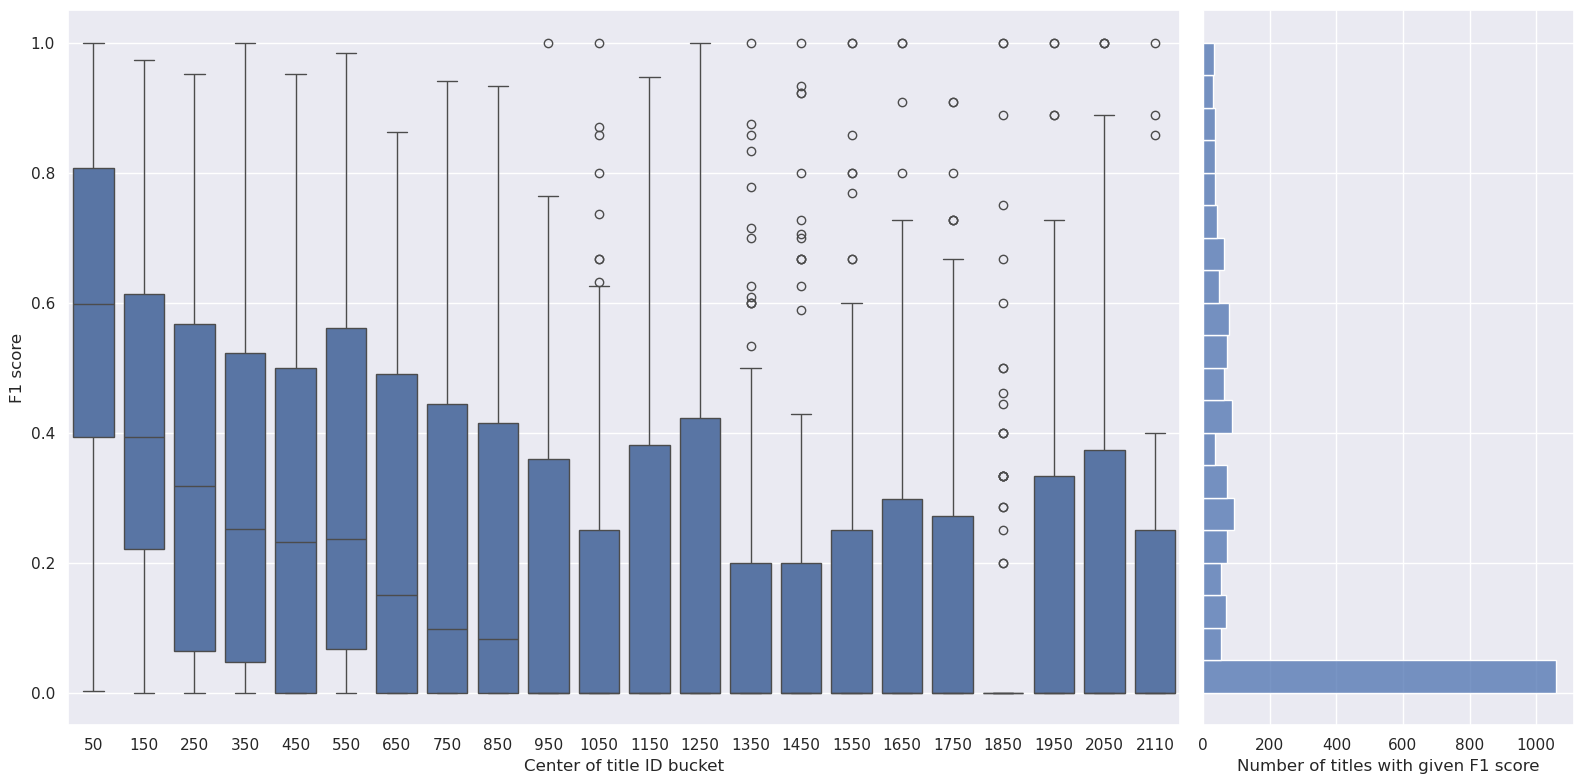

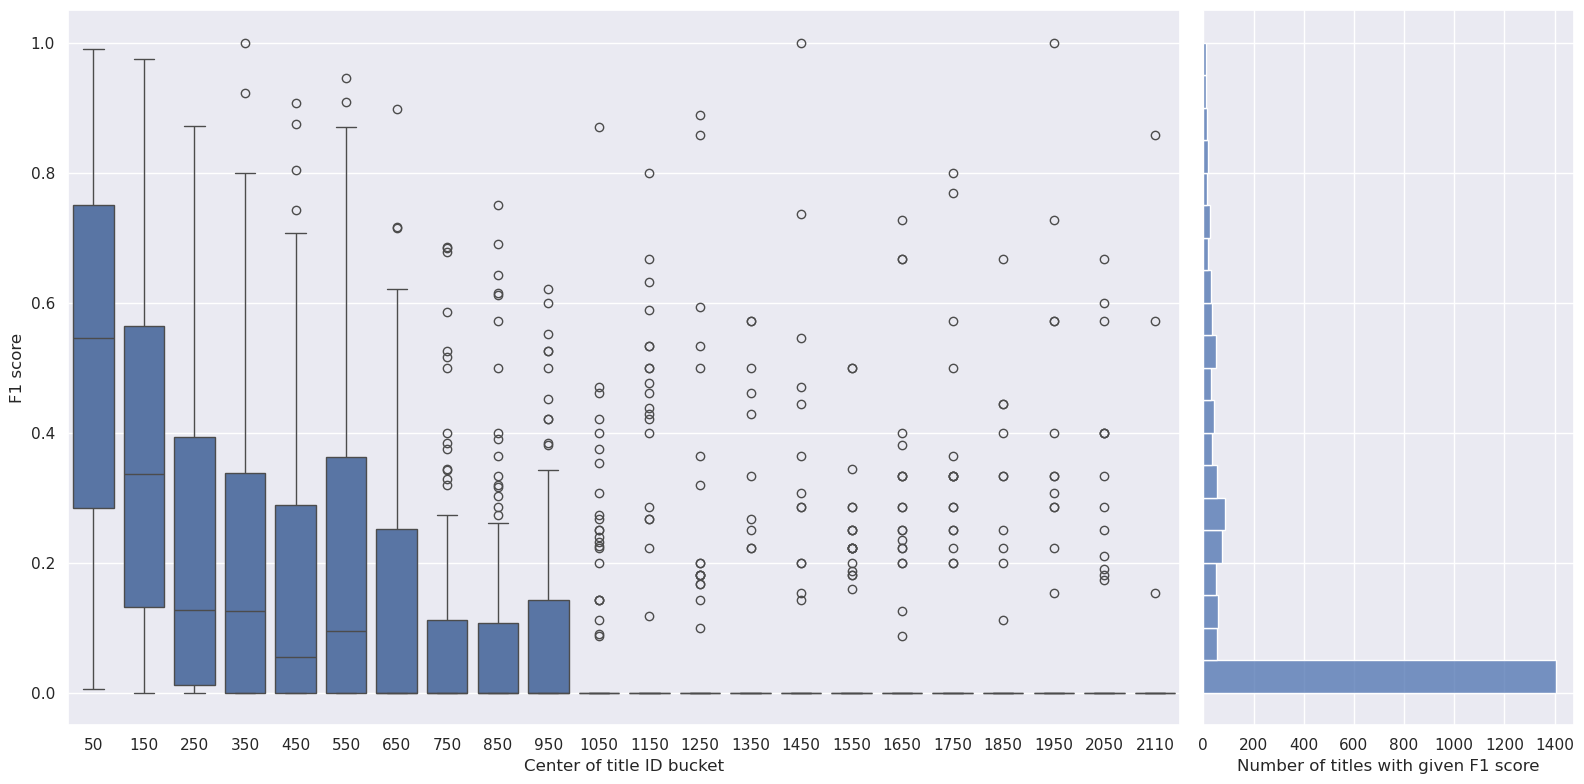

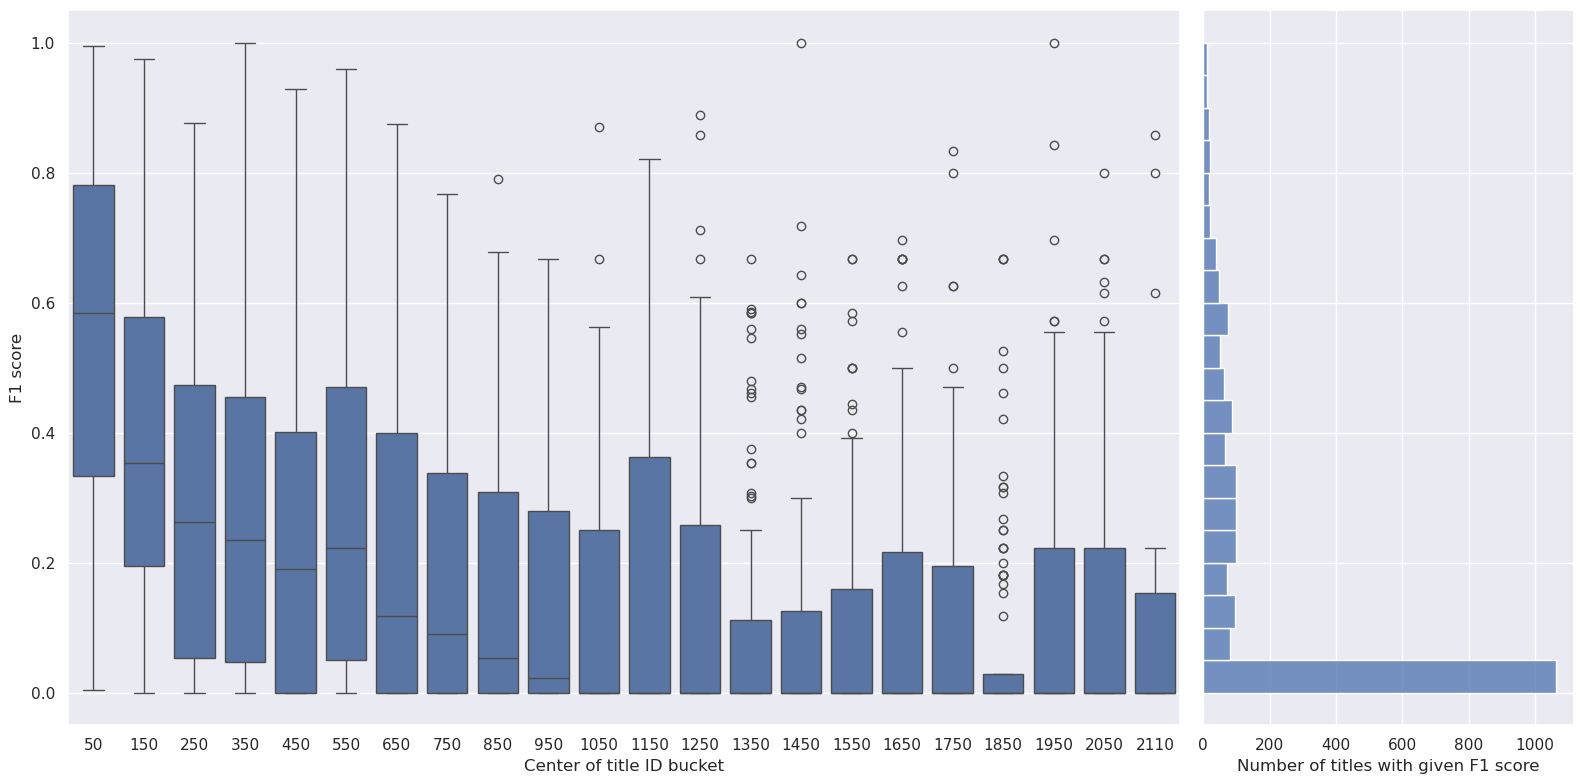

In [28]:
model_fcn = lambda x: nn_lsa.predict(x, batch_size=512, verbose=0)
create_metrics(model_fcn, vectors_lsa_test, ds["test"]["label"], f"{outname}-lsa", 100000)

Doc2Vec - classification and clustering ----------------

Make Doc2Vec vectors

In [34]:
class TqdmProgress(CallbackAny2Vec):
    def __init__(self, total, inc=1, **kwargs):
        self.pbar = tqdm(total=total, **kwargs)
        self.inc = inc
    def on_epoch_end(self, model):
        self.pbar.update(self.inc)
    def on_train_end(self, model):
        self.pbar.close()

In [35]:
def make_tagged_document(row):
    return TaggedDocument(row["doc"], [row["label"]])

Vectorize the data

In [36]:
window=5
min_count=5
workers=4 
epochs=10

In [37]:
tqdm.pandas(desc=f'  > Tagging documments')
x = ds["train"].progress_apply(make_tagged_document, axis=1)

  > Tagging documments: 100%|██████████| 3761672/3761672 [00:30<00:00, 124330.87it/s]


In [ ]:
tqdmcb = TqdmProgress(epochs, desc="  > Training doc2vec, epoch")
model = Doc2Vec(
    x.to_list(), vector_size=dim, window=window,
    min_count=min_count, workers=workers, epochs=epochs,
    callbacks=[tqdmcb]
)

  > Training doc2vec, epoch:  40%|████      | 4/10 [08:11<12:09, 121.50s/it]

In [ ]:
tqdm.pandas(desc=f'  > Infering train vectors')
vectors_train_doc2vec = ds["train"].doc.progress_apply(model.infer_vector)

In [ ]:
tqdm.pandas(desc=f'  > Infering test vectors')
vectors_test_doc2vec = ds["test"].doc.progress_apply(model.infer_vector)

Classification with Doc2Vec

In [ ]:
nn_d2v = make_model(vectors_train_doc2vec, len(titles), dropout=0.0)
nn_d2v.summary()

nn_d2v.fit(
    x=np.stack(vectors_train_doc2vec), y=ds["train"].label,
    batch_size=512,
    epochs=10,
    validation_split=0.1,
)

In [ ]:
print("> Making Doc2Vec Predictions")
model_fcn = lambda x: nn_d2v.predict(x, batch_size=512, verbose=0)
create_metrics(model_fcn, vectors_test_doc2vec, ds["test"]["label"], f"{outname}-d2v", 100000)

Clustring